# Audio feature extraction

This is a tutorial on spectral audio features commonly used in audio applications.

In [1]:
from __future__ import print_function

import matplotlib.pyplot as plt
import numpy as np
import librosa as lb # module for audio feature extraction
%matplotlib inline

/home/florencia/venvs/py2venv/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


### Load an audio file

In [2]:
wavF = '/home/florencia/whales/data/Vocal-repertoire-catalogue-Pilot-whales-Norway/NPW-33/2009-07-13-J/NPW-033-J-B-090713_f50-8_00_03_29.wav'

## The waveform

Time series of sound

Amplitude of oscilation of air pressure waves

sampling rate:  48000 
waveform size: 55867
1.16389583333


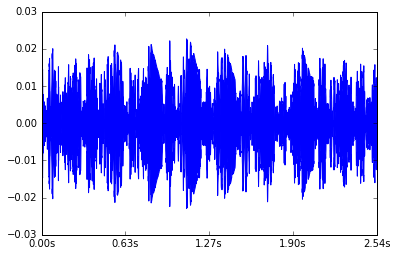

In [3]:
y, sr = lb.load(wavF, sr=None) # default sr=22050
print("sampling rate: ", sr, "\nwaveform size:", len(y))
tf = 1.*len(y)/sr
print(tf)
lb.display.waveplot(y)

## Spectrogram

Is a useful way to represent an audio signal in terms of its frequency components
and is given by the square of the magnitude of the STFT

$P_i(k) = \frac{1}{N} \left| S_i(k) \right| ^2$

Computing the short time fourier tranform along a framed signal.

For visualisation purposes worth looking at the spectrogram in logsale.
We can use librosa's logamplitude function to log scale the spectrogram within (amin=1e-10, top_db=80.0). The obtained spectro is proportional to the log spectro.


Table of parameters


| Waveform \
|---|---|
| sr | seconds  | sampling rate  |
| f | Hz  | Nyquist frequency  |
| Spectrum |
|---|
| NFFT  |   | short time Fourier transform  |
|---|
| Mel-spectrum |
|---|---|---|
| n_mels | |number of Mel filters|
|---|

In [33]:
NFFT = 2**8
overlap = 0.5
spec_y, n_fft = lb.core.spectrum._spectrogram(y, n_fft=NFFT, 
                                              hop_length=int(NFFT*overlap))
nf, nt =  np.shape(spec_y)
print("#freqs:", nf, "\n#times:", nt, "\nNFFT:", n_fft)


#freqs: 129 
#times: 437 
NFFT: 256


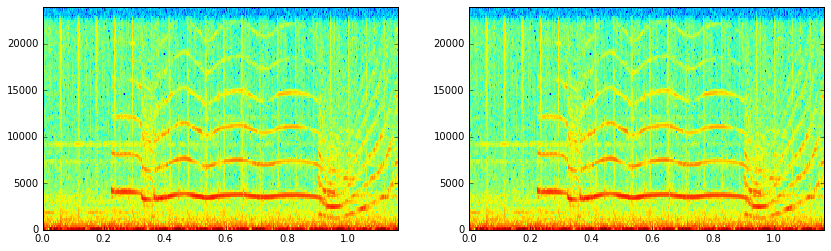

In [34]:
plt.figure(figsize=(14,4))
plt.subplot(121)
plt.imshow(np.log(spec_y), aspect='auto', origin='bottom', interpolation='nearest',
          extent=[0, tf, 0, sr/2])
plt.subplot(122)
plt.imshow(lb.core.logamplitude(spec_y), aspect='auto', origin='bottom', interpolation='nearest',
          extent=[0, tf, 0, sr/2])

#librosa.display.specshow(np.log(spec_y ), sr=sr)

### Mel spectrum

A scaled version of the spectrogram that resambles sound perception.
Prioritizes lower frequencies.
A mapping between the linear frqeuncies in [Hz] into the Mel scale can be obtained with
$$
M(f) = 1125 \ln (1 + f/700)
$$

The Mel-spectrum can be computed applying a filterbanck over the spectrogram.

For that we create the **Mel-filterbank** to wrapp the frequencies into the Mel-scale.


mel basis: (20, 129) 
spectrogram: (129, 437)


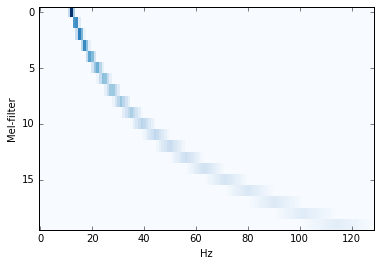

In [35]:
n_mels = 20
fmin=2000
mel_basis = lb.filters.mel(sr, n_fft=NFFT, n_mels=n_mels, fmin=fmin)
print("mel basis:", np.shape(mel_basis), "\nspectrogram:", np.shape(spec_y))

plt.imshow(mel_basis, aspect='auto', cmap=plt.cm.Blues, interpolation='nearest')
plt.ylabel('Mel-filter')

plt.xlabel('Hz')

### The Mel-filters

The filters are scaled to have approximately constant energy.

#mel filters : 20
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


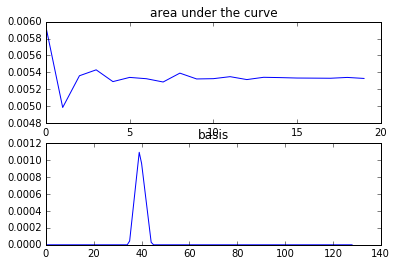

In [36]:
print("#mel filters :", len(mel_basis))
### Area of the mel filters
plt.subplot(2,1,1)
plt.title('area under the curve')
plt.plot([np.trapz(mel_basis[i,:]) for i in np.arange(len(mel_basis))])

### plot filters
plt.subplot(2,1,2)
plt.title('basis')
plt.plot( mel_basis[10,:])
#plt.plot(mel_basis[10,:])
#plt.plot(mel_basis[50,:])
#plt.plot(mel_basis[100,:])
#plt.plot(mel_basis[120,:])

print(mel_basis[10,10:25])

Applying the filterbank to the spectrum (not in log scale) we obtain the **Mel-spectrogram**

mel basis: (20, 129) 
spectrogram: (129, 437) 
mel-spectrum: (20, 437) 
NFFT: 256 
#mels: 20


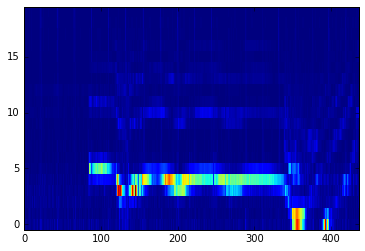

In [37]:
mel_spec_y = np.dot(mel_basis, spec_y) # matrix mutiplication
print("mel basis:", np.shape(mel_basis), "\nspectrogram:", np.shape(spec_y),
      "\nmel-spectrum:", np.shape(mel_spec_y), 
     "\nNFFT:", NFFT,
     "\n#mels:", n_mels,)
#     "\n#ceps:", n_mfcc)

plt.imshow(mel_spec_y, aspect='auto', origin='bottom', interpolation='nearest')

Now in log-scale.

Because the n_fft determines the number of frequency channels in the spectrogram (=n_fft/2), when the the number of mel filters is close the n_fft is not posible to map the linear frequency into the Mel-scaled ones, especially at lower frquencies where more resolution is demanded.

range (log): -6.14540057126 -13.2503284322 
range (lb-log amp): -26.6891355718 -57.5454452153


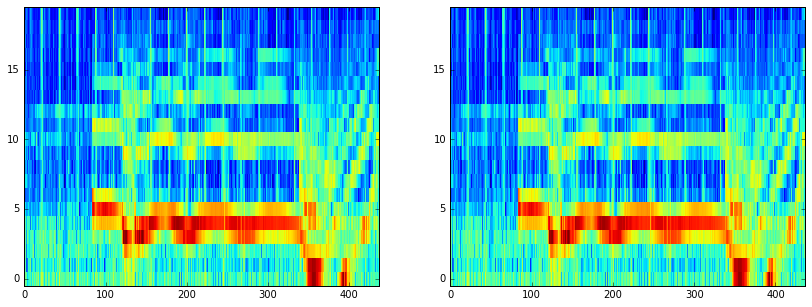

In [31]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.imshow(np.log(mel_spec_y), aspect='auto', origin='bottom', interpolation='nearest')
plt.subplot(1,2,2)
plt.imshow(lb.core.logamplitude(mel_spec_y), aspect='auto', origin='bottom', interpolation='nearest')

print('range (log):', np.max(np.log(mel_spec_y)), np.min(np.log(mel_spec_y)), 
      '\nrange (lb-log amp):',
      np.max(lb.core.logamplitude(mel_spec_y)), np.min(lb.core.logamplitude(mel_spec_y)))

#### Zero filters

Here we explore the relation between the NFFT and the n_mels.
At what point do we start having zeroing Mel-filters?
More or less around n_mels = NFFT/6

In [41]:
def myMelspec(y, sr, NFFT, n_mels=128, overlap=0):
    spec_y, n_fft = lb.core.spectrum._spectrogram(y, n_fft=NFFT, 
                                              hop_length=int(NFFT*overlap))
    mel_basis = lb.filters.mel(sr, n_fft=NFFT, n_mels=n_mels)#, fmin=1000)
    mel_spec_y = np.dot(mel_basis, spec_y) # matrix mutiplication
    return mel_spec_y
    
    
def hasZerosTheFilterbank(sr, n_fft, n_mels):
    '''True : filterbank has zeros, False otherwise'''
    mel_basis = lb.filters.mel(sr, n_fft=NFFT, n_mels=n_mels)
    zeroscounter = 0
    for i in np.arange(len(mel_basis)):
        if np.trapz(mel_basis[i,:]) <= 0.0:
            # print(i, "is zero")
            zeroscounter+=1

        return zeroscounter

### check if the filterbank has zeroing filters
sr=48*1000
NFFT = 2**7
print("PARAMS", sr, NFFT)
print("{}\t{}\t{}".format('NFFT', 'nmels', 'n_zeros' ), end='\n')
for NFFTpow in np.arange(4,12):
    nfft = 2**NFFTpow
    for nmels in np.arange(nfft//8, nfft//5):
        n_zeros = hasZerosTheFilterbank(sr, nfft, nmels)        
        if n_zeros==1:
            print("{}\t{}\t{}".format(nfft, nmels, n_zeros ), end='\n')
            break
        

PARAMS 48000 128
NFFT	nmels	n_zeros
128	21	1
256	32	1
512	64	1
1024	128	1
2048	256	1


## MFCC

In [15]:
log_mel_spec_y = lb.core.logamplitude(mel_spec_y)
n_mfcc = n_mels#/2
dct_filt = lb.filters.dct( n_mfcc, n_mels)

print(log_mel_spec_y.shape[0],
      np.shape(dct_filt),
      "\nNFFT:", NFFT,
      "\n#mels:", n_mels,
      "\n#ceps:", n_mfcc)


128 (128, 128) 
NFFT: 512 
#mels: 128 
#ceps: 128


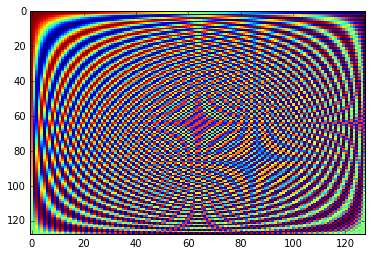

In [16]:
plt.imshow(dct_filt, aspect='auto', interpolation='nearest')

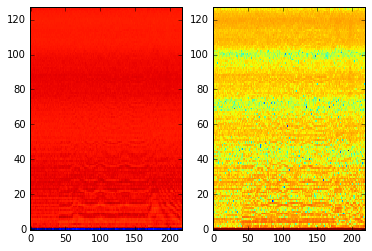

In [17]:
mfcc_y = np.dot(dct_filt, log_mel_spec_y)
plt.subplot(1,2,1)
plt.imshow(mfcc_y[:,:], aspect='auto', origin='bottom', interpolation='nearest')
plt.subplot(1,2,2)
plt.imshow(lb.core.logamplitude(mfcc_y[:,:]), aspect='auto', origin='bottom', interpolation='nearest')


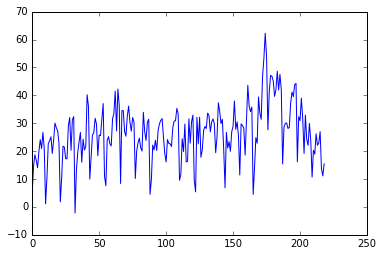

In [18]:
plt.plot(mfcc_y[1,:])

## Onset detection --> clicks

In [19]:
onset_frames = lb.onset.onset_detect(y, sr)
timeOnsets = lb.frames_to_time(onset_frames, sr)

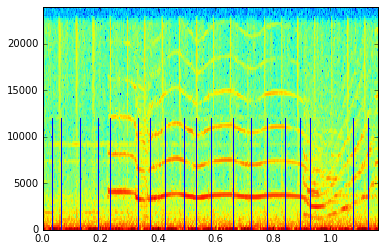

In [20]:
NFFT = 2**8
overlap = 0.5
spec_y, n_fft = lb.core.spectrum._spectrogram(y, n_fft=NFFT, 
                                              hop_length=int(NFFT*overlap))

plt.imshow(lb.core.logamplitude(spec_y), aspect='auto', origin='bottom', interpolation='nearest',
          extent=[0, tf, 0, sr/2])

for to in timeOnsets[:]:
    plt.axvline(to, ymax=0.50)#, ymin=1000)

In [27]:
sc = lb.feature.spectral_centroid(y, sr )
print(np.shape(sc))
sc = lb.feature.spectral_bandwidth(y, sr )
print(np.shape(sc))
sc = lb.feature.melspectrogram(y, sr )
print(np.shape(sc))

(1, 110)
(1, 110)
(128, 110)


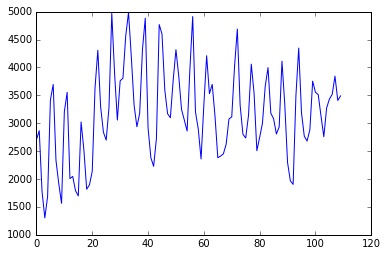

In [25]:
plt.plot(sc[0])